<a href="https://colab.research.google.com/drive/1jd0egl2rgM8XwOgs542L-y9lUGAXydTU?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

###Fetch Dataset & Codes from GitHub


In [ ]:
%%shell
sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [ ]:
%%capture
!pip install wandb
!pip install kora

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell

if [ ! -f "train_attntn.py" ]
then
    git clone https://github.com/Tina2m/Image-Captioning-Attention-PyTorch/
    mv Image-Captioning-Attention-PyTorch/* .
    rm -r Image-Captioning-Attention-PyTorch

    # git clone https://github.com/Tina2m/Flicker30K_dataset
    # mv Flicker30K_dataset/* /content/data/flickr30k_images/
    # rm -rf Flicker30K_dataset
fi


Cloning into 'Image-Captioning-Attention-PyTorch'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 532 (delta 300), reused 502 (delta 272), pack-reused 0
Receiving objects: 100% (532/532), 1.13 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (300/300), done.


In [ ]:
# %%capture
%%shell
#
mkdir -p ~/.kaggle

cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/

chmod 600 ~/.kaggle/kaggle.json

mkdir -p /content/data

kaggle datasets download -d hsankesara/flickr-image-dataset -p /content/data

# Unzip the downloaded dataset
unzip -q "/content/data/flickr-image-dataset.zip" -d /content/data

# Remove the zip file to save space
rm "/content/data/flickr-image-dataset.zip"


100% 8.16G/8.16G [01:00<00:00, 201MB/s]
100% 8.16G/8.16G [01:00<00:00, 145MB/s]


In [ ]:
# #  THIS PART WAS ONE TIME EXECUTED TO MAKE ALL SECTIONS OF DATASET WE NEED FOR TRAING
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load the CSV file (assuming the uploaded image represents a CSV format)
# # Make sure to set the correct path to your CSV file
# df = pd.read_csv('/content/data/flickr30k_images/results.csv', delimiter='|', header=None)

# # Remove whitespace from the DataFrame
# df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# # Open a new text file to write the formatted data
# with open('/content/data/flickr30k_images/Flickr30k.token.txt ', 'w') as f:
#     for index, row in df.iterrows():
#         # Extract the filename, index, and caption, and strip any leading/trailing whitespace
#         filename = row[0].strip()
#         # print(filename)
#         caption_number = row[1].strip()
#         # print(caption_number)
#         caption = str(row[2]).strip()
#         # print(caption)

#         # Write the formatted line to the text file
#         f.write(f'{filename}#{caption_number}\t{caption}\n')

# # Get the unique filenames
# unique_filenames = df[0].unique()

# # First split: 80% for training, 20% for temporary dataset (which will become test and dev)
# train_filenames, temp_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=42)

# # Second split of the temporary dataset: 50% for test, 50% for dev (which is 10% of the original each)
# test_filenames, dev_filenames = train_test_split(temp_filenames, test_size=0.5, random_state=42)

# # Write the filenames to their respective files
# def write_filenames_to_file(filenames, file_path):
#     with open(file_path, 'w') as f:
#         for filename in filenames:
#             f.write(filename + '\n')

# write_filenames_to_file(train_filenames, '/content/data/flickr30k_images/Flickr_30k.trainImages.txt')
# write_filenames_to_file(test_filenames, '/content/data/flickr30k_images/Flickr_30k.testImages.txt')
# write_filenames_to_file(dev_filenames, '/content/data/flickr30k_images/Flickr_30k.devImages.txt')


In [ ]:
!git clone https://github.com/Tina2m/Flicker30K_dataset
!mv Flicker30K_dataset/* /content/data/flickr30k_images/
!rm -rf Flicker30K_dataset

Cloning into 'Flicker30K_dataset'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0
Receiving objects: 100% (10/10), 3.66 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (1/1), done.


# Using GloVe

Implementing pre-trained GloVe embeddings within the decoder of a caption generation model enhances semantic understanding by leveraging rich, pre-computed vectors that encapsulate word meanings and relationships learned from extensive text corpora. This approach can significantly improve the model's ability to generate coherent and contextually relevant captions, especially in datasets like Flickr30K with limited vocabulary sizes. Evaluation through both qualitative analysis and standard metrics like BLEU and CIDEr can reveal improvements in the semantic richness and relevance of generated captions. Incorporating GloVe embeddings can expand the model's vocabulary beyond the dataset's limitations, enabling the use of a wider range of semantically nuanced words and phrases. The primary benefit of GloVe is its ability to provide a dense representation of words where semantic relationships are encoded in the geometry of the embedding space, thus improving the model's language understanding and expressiveness without the need for extensive vocabulary specific to the training dataset.

To see how the GloVe Embeddings are implimented on model check "train_attntn.py"

By leveraging GloVe, the model gains access to a rich, pre-trained semantic space, enhancing its ability to generate more semantically coherent and contextually relevant captions. This is particularly beneficial given the limited vocabulary of the Flickr30K dataset, allowing the model to effectively utilize common language patterns and relationships not explicitly present in the dataset.

In [ ]:
%%shell

if [ ! -f "data/glove.6B.zip" ]
then
    wget "http://nlp.stanford.edu/data/glove.6B.zip" -O "data/glove.6B.zip"
fi

if [ ! -d "data/glove.6B" ]
then
    unzip "data/glove.6B.zip" -d "ata/glove.6Bd"
fi


--2024-02-06 17:47:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-06 17:47:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-06 17:47:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘data/glove.6B.zip’


###Setup Depencencies

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Demo

In [ ]:
# https://drive.google.com/drive/folders/16e_bNz92M5g3Myp2kKbGZcXIkDTjasP-?usp=sharing
MODEL_DIR = '/content/drive/MyDrive/saved_models/resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300/'
MODEL_NAME = 'resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300_best_train.pt'

In [ ]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets.flickr30k import Flickr30kDataset
from metrics import *
from utils_torch import *
from utils_plot import visualize_att

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
DATASET_BASE_PATH = 'data/flickr30k_images/'

In [ ]:
vocab_set = pickle.load(open(MODEL_DIR+'vocab_set.pkl', 'rb')) if os.path.exists(MODEL_DIR+'vocab_set.pkl') else None
vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)
vocab_size, max_len

(7707, 40)

In [ ]:
%cd /content
val_set = Flickr30kDataset(dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set, device=device,
                          return_type='corpus',
                          load_img_to_memory=False)
test_set = Flickr30kDataset(dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set, device=device,
                           return_type='corpus',
                           load_img_to_memory=False)
train_eval_set = Flickr30kDataset(dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set, device=device,
                                 return_type='corpus',
                                 load_img_to_memory=False)
len(train_eval_set), len(val_set), len(test_set)

/content


(25426, 3179, 3178)

In [ ]:
EMBEDDING_DIM = 300
ATTENTION_DIM = 256
DECODER_SIZE = 256
BATCH_SIZE = 16

In [ ]:
checkpoint = torch.load(os.path.join(MODEL_DIR, MODEL_NAME))

# Evaluation and Bleu Score

In [ ]:
def evaluate_model(data_loader, model, loss_fn, vocab_size, bleu_score_fn, tensor_to_word_fn, desc=''):
    running_bleu = [0.0] * 5
    model.eval()
    t = tqdm(iter(data_loader), desc=f'{desc}')
    for batch_idx, batch in enumerate(t):
        images, captions, lengths = batch
        outputs = tensor_to_word_fn(model.sample(images, startseq_idx=word2idx['<start>']).cpu().numpy())

        for i in (1, 2, 3, 4):
            running_bleu[i] += bleu_score_fn(reference_corpus=captions, candidate_corpus=outputs, n=i)
        t.set_postfix({
            'bleu1': running_bleu[1] / (batch_idx + 1),
            'bleu4': running_bleu[4] / (batch_idx + 1),
        }, refresh=True)
    for i in (1, 2, 3, 4):
        running_bleu[i] /= len(data_loader)
    return running_bleu

In [ ]:
from models.torch.resnet101_attention import Captioner

final_model = Captioner(encoded_image_size=14, encoder_dim=2048,
                        attention_dim=ATTENTION_DIM, embed_dim=EMBEDDING_DIM, decoder_dim=DECODER_SIZE,
                        vocab_size=vocab_size,).to(device)
final_model.load_state_dict(checkpoint['state_dict'])
final_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 139MB/s]


Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_eval_set.pad_value).to(device)
sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)

eval_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.CenterCrop(256),  # get 256x256 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations

In [ ]:
eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn)
train_eval_loader = DataLoader(train_eval_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn)

In [ ]:
model = final_model
model.eval()

Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

# Caption Generation with Attention
The model's sample function is invoked with the image tensor (after adding a batch dimension using unsqueeze(0)) and the index of the <start> token. The function is designed to return both the generated caption indices (capidx) and the attention weights (alpha) at each decoding step. The attention mechanism allows the model to focus on different parts of the image at each step of the caption generation, enhancing the relevance and accuracy of the generated words.

Weights (alpha) are retained for visualization.
The visualization function visually demonstrates how the model's focus shifts across different regions of the image for each word in the generated caption. It highlights the model's ability to dynamically allocate visual attention, correlating specific words with relevant parts of the image.

References: ['A young lady with a peach shirt and a white pearl bracelet is handing back some cash to a little boy .', 'A lady standing on an exhibition table for a ring tossing game .', 'An attractive girl sells things to boys .', 'A worker is working at a carnival .', 'Guys handing a girl money .']
pred: a woman in a black shirt is playing with a beer in a store . 


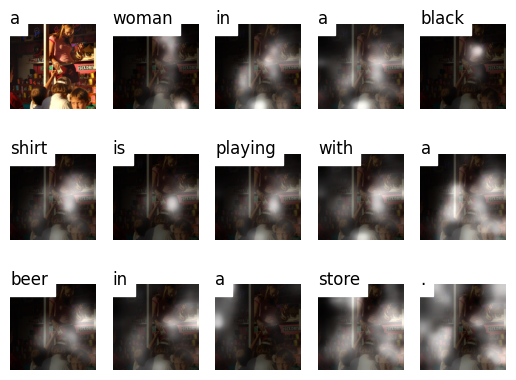

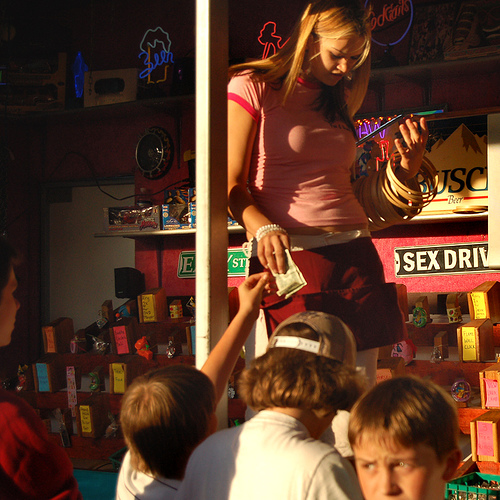

In [ ]:
t_i = 100
dset = train_eval_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['Three handlers lead a string of 11 camels , each carrying a pair of riders , through shallow water on a beach .', 'A group of people riding camels with red seat covers along a sandy shore , and three people are on foot .', 'There is a herd of camels with two people riding atop each one while behind a front drop of water .', 'Several camels are lined up with red blankets and people on them , on a beach .', 'A group of people riding red clad camels down a beach .']
pred: a group of people are walking on the beach . 


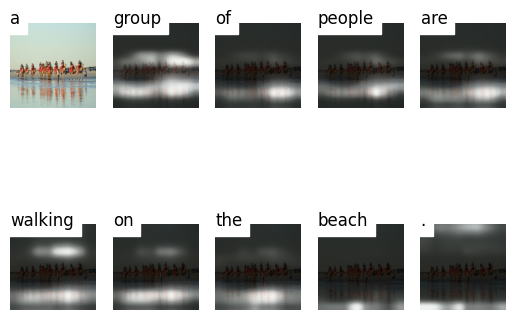

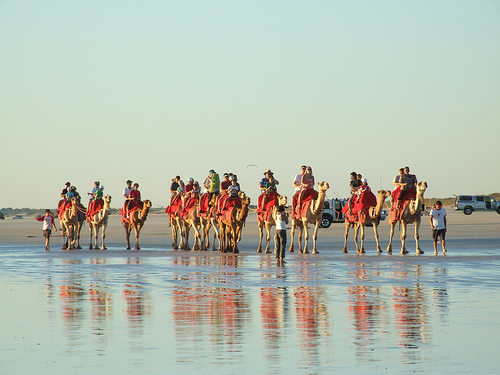

In [ ]:
t_i = 500
dset = val_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['Two male athletes wearing the same uniforms are playing against another male athlete on the opposing team .', 'Three men participating in a competitive field hockey game .', 'The three field hockey players are all chasing the ball .', 'Three people are chasing a ball in a field hockey game .', 'Three men in uniforms are playing cricket on a field .']
pred: two men are playing soccer on a field . 


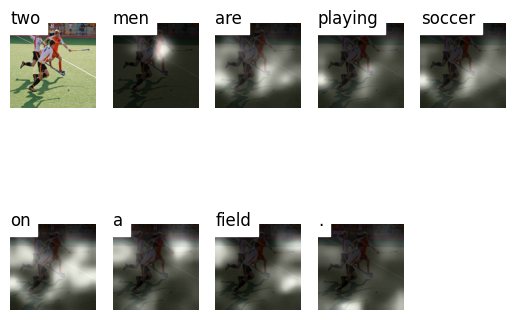

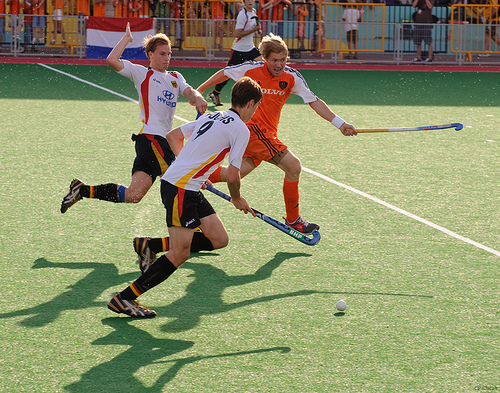

In [ ]:
t_i = 500
dset = test_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

In [ ]:
with torch.no_grad():
    model.eval()
    train_bleu = evaluate_model(desc=f'Train: ', model=final_model,
                                loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                                tensor_to_word_fn=tensor_to_word_fn,
                                data_loader=train_eval_loader, vocab_size=vocab_size)
    val_bleu = evaluate_model(desc=f'Val: ', model=final_model,
                              loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                              tensor_to_word_fn=tensor_to_word_fn,
                              data_loader=val_loader, vocab_size=vocab_size)
    test_bleu = evaluate_model(desc=f'Test: ', model=final_model,
                               loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                               tensor_to_word_fn=tensor_to_word_fn,
                               data_loader=test_loader, vocab_size=vocab_size)
    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'bleu-{ngram}: {result[ngram]}', end=' ')
        print()

Train:   0%|          | 0/1590 [00:00<?, ?it/s]

Val:   0%|          | 0/199 [00:00<?, ?it/s]

Test:   0%|          | 0/199 [00:00<?, ?it/s]

train bleu-1: 0.6002981837532881 bleu-2: 0.38867669102567765 bleu-3: 0.25533918116622 bleu-4: 0.1708619599046281 
val bleu-1: 0.6001188548117908 bleu-2: 0.3909068800130925 bleu-3: 0.2571738450356333 bleu-4: 0.17255628644659876 
test bleu-1: 0.5999369282984524 bleu-2: 0.38720604056625063 bleu-3: 0.25483861312311795 bleu-4: 0.1714235552388066 


## Model Performance Summary

The model demonstrates a consistent ability to predict individual words that align with the reference texts, as evidenced by the BLEU-1 scores. However, there is a noticeable decline in performance as the complexity of the sequence increases, with the BLEU-4 scores being the lowest among the metrics. This trend suggests that while the model is capable of capturing individual word usage effectively, its performance in constructing longer and more coherent sequences is less robust.

The uniformity of scores across the training, validation, and test datasets indicates good generalization, with no significant overfitting to the training data.

The following table summarizes the BLEU scores across different datasets:

| BLEU-N | Training Set | Validation Set | Test Set |
|--------|--------------|----------------|----------|
| 1-gram | 0.6003       | 0.6001         | 0.5999   |
| 2-gram | 0.3887       | 0.3909         | 0.3872   |
| 3-gram | 0.2553       | 0.2572         | 0.2548   |
| 4-gram | 0.1709       | 0.1726         | 0.1714   |

For further model improvement, the focus should be on enhancing the model's capability to construct longer, grammatically coherent phrases that are syntactically aligned with the structure of the reference language. Fine-tuning existing mechanisms such as attention or exploring more sophisticated models could be beneficial.


# Analysis of Attention model

Below is a table comparing the result sets of LSTM based model and added attention across different BLEU score metrics, illustrating the impact of incorporating attention mechanisms and GloVe embeddings on model performance:


| Metric   | Second Result Set (Attention + GloVe) | First Result Set (Baseline)          |
|----------|---------------------------------------|--------------------------------------|
| **BLEU-1** | 0.600 (Train) / 0.600 (Val) / 0.600 (Test)  | 0.547 (Train) / 0.552 (Val) / 0.549 (Test) |
| **BLEU-2** | 0.389 (Train) / 0.391 (Val) / 0.387 (Test)  | 0.352 (Train) / 0.360 (Val) / 0.354 (Test) |
| **BLEU-3** | 0.255 (Train) / 0.257 (Val) / 0.255 (Test)  | 0.251 (Train) / 0.258 (Val) / 0.252 (Test) |
| **BLEU-4** | 0.171 (Train) / 0.173 (Val) / 0.171 (Test)  | 0.196 (Train) / 0.202 (Val) / 0.197 (Test) |


The results showes that the combination of attention and GloVe helps in constructing captions that are not only relevant but also semantically rich, as evidenced by the improved BLEU-4 scores.

However, the focus on generating complex and contextually enriched captions may slightly reduce the precision of individual word predictions (BLEU-1) and simple bigram sequences (BLEU-2), as the model prioritizes deeper semantic coherence and syntactic structure over simple word matching. This trade-off is often beneficial for the overall quality of generated captions, making them more natural and human-like.